In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import sys
import os

# Add src to path
sys.path.append('../../src')

from terrain_navigate.environments import GridEnvironment
from terrain_navigate.algorithms import AStar
from terrain_navigate.costs import EuclideanCost, ApproachOneCost, ApproachTwoCost

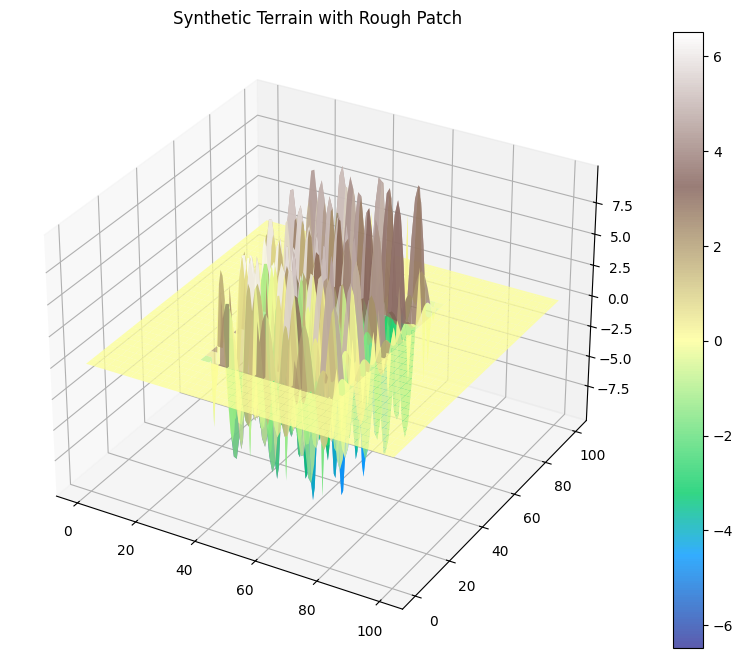

In [2]:
def generate_terrain(width=100, height=100):
    x = np.linspace(0, 100, width)
    y = np.linspace(0, 100, height)
    X, Y = np.meshgrid(x, y, indexing='ij')
    
    Z = np.zeros_like(X)
    
    # Create a "rough" patch in the middle
    # The patch covers x in [30, 70] and y in [20, 80]
    # Outside this y-range, it is flat.
    
    mask_x = (X >= 30) & (X <= 70)
    mask_y = (Y >= 20) & (Y <= 80)
    mask = mask_x & mask_y
    
    # Sinusoidal bumps
    # High frequency to make it "rough"
    # Z = 10 * sin(x/2) * cos(y/2)
    Z[mask] = 10.0 * np.sin(X[mask] * 0.5) * np.cos(Y[mask] * 0.5)
    
    return X, Y, Z

X, Y, Z = generate_terrain(101, 101)

# Visualize Terrain
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='terrain', alpha=0.8)
fig.colorbar(surf)
ax.set_title("Synthetic Terrain with Rough Patch")
plt.show()

In [3]:
# Setup Environment
env = GridEnvironment(
    Z=Z,
    global_x_min=0,
    global_x_max=100,
    global_y_min=0,
    global_y_max=100,
    resolution=1.0
)

# We need 3D points (x, y, z) for the algorithm because the environment is 3D
start_z = Z[10, 50]
goal_z = Z[90, 50]
start = np.array([10.0, 50.0, start_z])
goal = np.array([90.0, 50.0, goal_z])

astar = AStar()

# Define Costs
costs = {
    "Euclidean": EuclideanCost(),
    "Elevation Penalty (Approach 1)": ApproachOneCost(n=4.0), # Higher n to penalize hills more
    "Slope Penalty (Approach 2)": ApproachTwoCost(n1=4.0, n2=4.0)
}

paths = {}

for name, cost_fn in costs.items():
    print(f"Running A* with {name}...")
    path, cost = astar.find_path(start, goal, env, cost_fn)
    if path is not None:
        paths[name] = path
        print(f"  Found path with cost {cost:.2f}")
    else:
        print("  No path found!")

Running A* with Euclidean...
  Found path with cost 82.10
Running A* with Elevation Penalty (Approach 1)...
  Found path with cost 82.17
Running A* with Slope Penalty (Approach 2)...
  Found path with cost 82.23


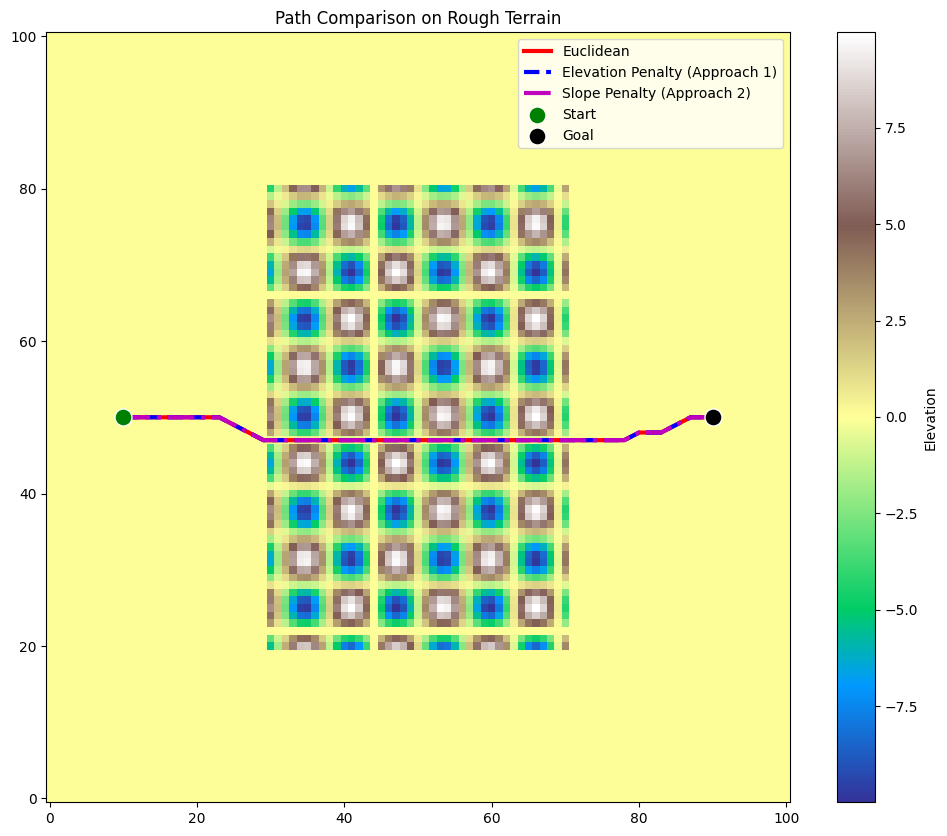

In [4]:
# Visualization of Paths
fig, ax = plt.subplots(figsize=(12, 10))

# Plot terrain as heatmap
c = ax.pcolormesh(X, Y, Z, cmap='terrain', shading='auto')
fig.colorbar(c, ax=ax, label='Elevation')

# Plot paths
colors = ['r', 'b', 'm']
styles = ['-', '--', '-.']

for i, (name, path) in enumerate(paths.items()):
    ax.plot(path[:, 0], path[:, 1], color=colors[i], linestyle=styles[i], linewidth=3, label=name)

ax.scatter(start[0], start[1], color='g', s=150, label='Start', zorder=10, edgecolors='white')
ax.scatter(goal[0], goal[1], color='k', s=150, label='Goal', zorder=10, edgecolors='white')

ax.set_title("Path Comparison on Rough Terrain")
ax.legend()
plt.show()